In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Knowing that the JSON file is structured with each line as a separate JSON object
philly_reviews_df = pd.read_json('../data/philadelphia_restaurant_reviews.json', lines=True)

In [3]:
# Convert the 'date' column to datetime format
philly_reviews_df['date'] = pd.to_datetime(philly_reviews_df['date'])

In [4]:
# Extract the hour from the 'date' column
philly_reviews_df['hour'] = philly_reviews_df['date'].dt.hour

In [5]:
# Group by hour and count the number of reviews for each hour
reviews_per_hour = philly_reviews_df.groupby('hour').size()

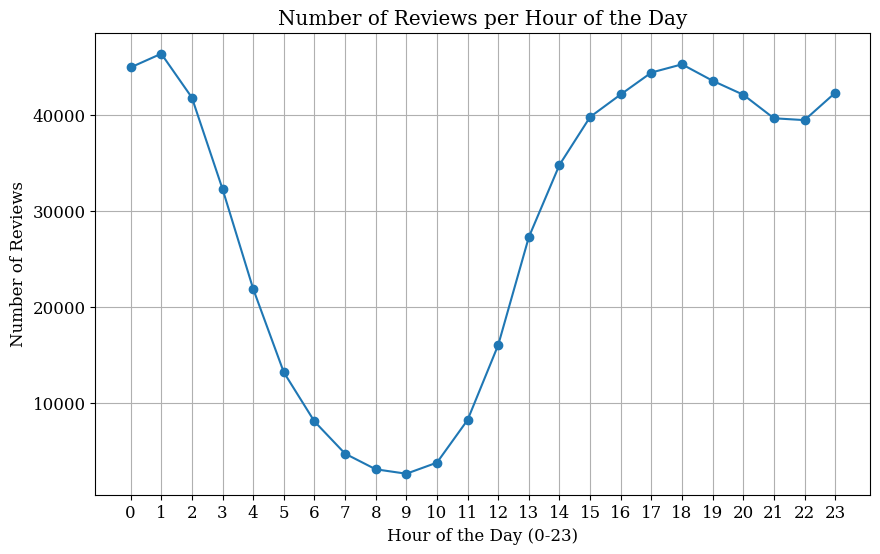

In [6]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12       
   
plt.figure(figsize=(10,6))
reviews_per_hour.plot(kind='line', marker='o')

plt.title('Number of Reviews per Hour of the Day')
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(range(0,24))
plt.show()

In [7]:
# Group by business_id and count the number of reviews
business_review_counts = philly_reviews_df.groupby('business_id').size()

# Find the business with the most reviews
top_business_id = business_review_counts.idxmax()
top_review_count = business_review_counts.max()

print(f"The business with the most reviews has business_id: {top_business_id}")
print(f"It has {top_review_count} reviews.")

The business with the most reviews has business_id: ytynqOUb3hjKeJfRj5Tshw
It has 5778 reviews.


In [8]:
# Load business dataset
business_df = pd.read_json('../data/yelp_academic_dataset_business.json', lines=True)

top_business_info = business_df[business_df['business_id'] == top_business_id]

top_business_name = top_business_info['name'].values[0]

print(f"The top business is: {top_business_name}")

The top business is: Reading Terminal Market


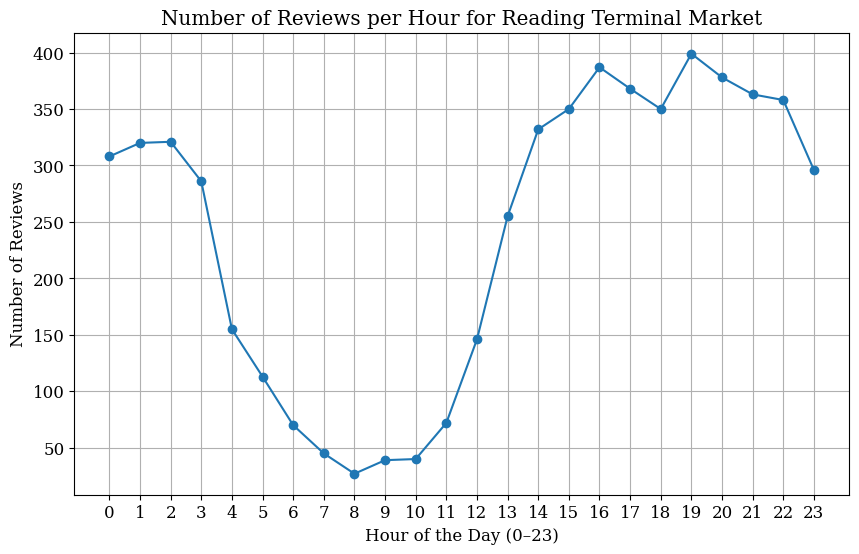

In [9]:
import matplotlib.pyplot as plt

# Filter reviews for the top business
top_business_reviews = philly_reviews_df[philly_reviews_df['business_id'] == top_business_id].copy()

# Convert 'date' to datetime
top_business_reviews['date'] = pd.to_datetime(top_business_reviews['date'])

# Extract the hour of the review
top_business_reviews['hour'] = top_business_reviews['date'].dt.hour

# Group by hour and count
reviews_per_hour = top_business_reviews.groupby('hour').size()

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(10,6))
reviews_per_hour.plot(kind='line', marker='o')

plt.title(f'Number of Reviews per Hour for {top_business_name}')
plt.xlabel('Hour of the Day (0–23)')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.xticks(range(0,24))
plt.show()


In [10]:
# Count number of reviews per business
review_counts = philly_reviews_df.groupby('business_id').size()

# Keep only businesses with at least 50 reviews
businesses_with_enough_reviews = review_counts[review_counts >= 50].index.tolist()


In [11]:
# Group reviews by business and hour, and calculate mean stars
business_hour_avg = philly_reviews_df.groupby(['business_id', 'hour'])['stars'].mean().reset_index()

# Calculate std for each business
business_variability = business_hour_avg.groupby('business_id')['stars'].std()

# Keep only businesses with enough reviews
business_variability = business_variability[business_variability.index.isin(businesses_with_enough_reviews)]

# Sort and pick top 3 businesses
top_variable_business_ids = business_variability.sort_values(ascending=False).head(3).index.tolist()

print(top_variable_business_ids)
print("Top 3 businesses with highest variation and their review counts:")
for business_id in top_variable_business_ids:
    count = review_counts[business_id]
    business_info = business_df[business_df['business_id'] == business_id]
    business_name = business_info['name'].values[0]
    print(f"- {business_name}: {count} reviews")


['97SR7RQPL02t5J41UcZ4SQ', 'jPG_BuIKf0KBCFY6u00h-A', 'fT0lXvUz41XaZbgtSMqTKg']
Top 3 businesses with highest variation and their review counts:
- Pat's Pizzeria: 51 reviews
- Love Park Pizza and Chicken: 55 reviews
- Mangiamo 444: 55 reviews


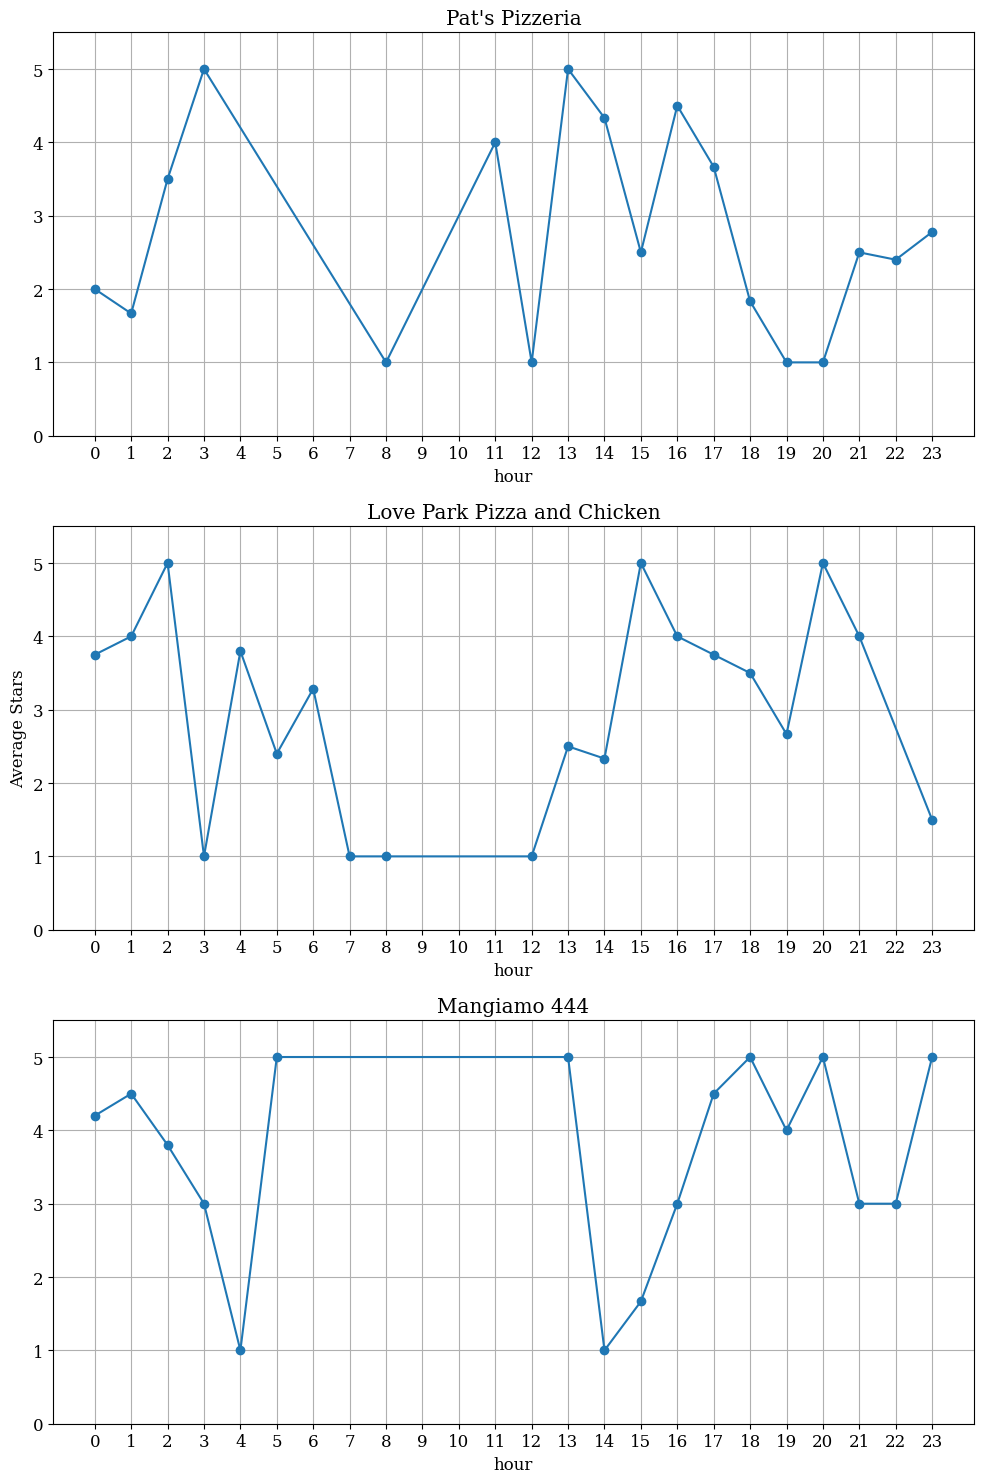

In [12]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

plt.figure(figsize=(10, 15))

for i, business_id in enumerate(top_variable_business_ids, 1):
    business_info = business_df[business_df['business_id'] == business_id]
    business_name = business_info['name'].values[0]

    reviews = philly_reviews_df[philly_reviews_df['business_id'] == business_id].copy()

    reviews['date'] = pd.to_datetime(reviews['date'])
    reviews['hour'] = reviews['date'].dt.hour

    stars_per_hour = reviews.groupby('hour')['stars'].mean()

    plt.subplot(3, 1, i)
    stars_per_hour.plot(kind='line', marker='o')
    plt.title(f'{business_name}')
    plt.ylim(0, 5.5)
    plt.grid(True)
    plt.xticks(range(0, 24))
    if i == 2:
        plt.ylabel('Average Stars')

plt.tight_layout()
plt.show()


In [13]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Select
from bokeh.layouts import column
from bokeh.io import push_notebook
import pandas as pd

# Enable Bokeh in the notebook
output_notebook()


Loading BokehJS ...

In [14]:
import pandas as pd
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import ColumnDataSource, FactorRange

output_notebook()

HighContrast10 = [
    "#1f77b4",  # Blue  
    "#ff7f0e",  # Orange  
    "#2ca02c",  # Green  
    "#d62728",  # Red  
    "#9467bd",  # Purple  
    "#8c564b",  # Brown  
    "#e377c2",  # Pink  
    "#7f7f7f",  # Gray  
    "#bcbd22",  # Olive  
    "#17becf"   # Teal  
]

# Prepare data
philly_reviews_df['date'] = pd.to_datetime(philly_reviews_df['date'])
philly_reviews_df['hour'] = philly_reviews_df['date'].dt.hour

# Create 3-hour time blocks
def map_three_hour_block(hour):
    start = (hour // 3) * 3
    end = start + 2
    return f"{start:02d}-{end:02d}"

philly_reviews_df['three_hour_block'] = philly_reviews_df['hour'].apply(map_three_hour_block)

# Count reviews per (star, time block)
grouped = philly_reviews_df.groupby(['stars', 'three_hour_block']).size().unstack(fill_value=0)

# Make sure columns are sorted by time
time_blocks = sorted(grouped.columns)
grouped = grouped[time_blocks]

for star in range(1, 6):
    if star not in grouped.index:
        grouped.loc[star] = [0] * len(time_blocks)

grouped = grouped.sort_index()
grouped.index = grouped.index.map(str)
stars = grouped.index.tolist()

grouped.reset_index(inplace=True)
grouped.rename(columns={'stars': 'stars'}, inplace=True)
source = ColumnDataSource(grouped)

p = figure(x_range=FactorRange(*stars),
           height=500, width=900,
           title="Review Counts per Star Rating across 3-Hour Blocks",
           toolbar_location="above", tools="pan,wheel_zoom,reset,save")

colors = HighContrast10

for i, block in enumerate(time_blocks):
    p.vbar(x='stars',
           top=block,
           source=source,
           width=0.2,
           color=colors[i % len(colors)],
           legend_label=block,
           muted_alpha=0.1,
           muted=False,
           alpha=0.7)

p.xaxis.axis_label = "Star Rating"
p.yaxis.axis_label = "Number of Reviews"
p.xaxis.major_label_orientation = 1.0
p.x_range.range_padding = 0
p.y_range.start = 0
p.title.text_font_size = "14pt"
p.legend.location = "top_left"
p.legend.click_policy = "mute"
p.add_layout(p.legend[0], 'left')

show(p)


Loading BokehJS ...